<img src="https://cdn3.dualshockers.com/wp-content/uploads/2015/11/Tom-Clancys-Rainbow-Six-Siege.jpg" alt="Drawing" style="width: 700px;"/>
<center>
<h1 style="font-size:36px;">Predicting the Chance of Winning in Rainbow Six Siege</h1>
<h4>
Charles Liu, Jules Iglesia</h4>
<hr>
<h1>Introduction</h1>
</center>
<body><p>
Rainbow Six Siege (R6S) is a MMORTG (Massively Multiplayer Online Real Time Strategy) first-person shooter game developed by Ubisoft. Released in December 2015, Siege only recently gained popularity and boasts 2.3 million players daily with over 25 million registered users. The premise of the game is simple: each game consists of two teams of 5 players, with one team labeled as the Attackers and one as the Defenders. Attackers are assigned a goal depending on the game mode, which ranges from extracting a hostage from a building or planting/detonating a bomb in a building. Each game consists of best of 5 or 7 rounds played in a random map used for all rounds, with each round ending if the Attackers objective is completed within a timeframe, time runs out, or all members of one side are eliminated. Players currently can choose from 68 maps, 36 unique operators, and several loadouts (primary weapon, secondary weapon, etc.) to use. *Full details can be found <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/index.aspx">here</a>. 
<p>
On June 27, 2017, a Game Intelligence Analyst on the Ubisoft R6S Development Team released datasets covering various metrics from in-game data. Along with this <a href="https://rainbow6.ubisoft.com/siege/en-us/news/152-293696-16/introduction-to-the-data-peek-velvet-shell-statistics">data release</a>, he revealed that analysts at Ubisoft work with several different teams and play an important role in the overall development of the game. Given the interesting statistics they were able to find, the Development Team decided to release some in-game data as a way to allow members of the community to conduct some of their own data analyses.
<p> 
In this tutorial, our goal is to tidy the in-game data given to us, provide valuable insight into which operators are the most successful in terms of win rate/kill-death ratio, and predict these win/kill-death ratios when a certain character is chosen in different situations. Operators are fundamentally different since each operator has a unique gadget or ability for use in each round. These range from being able to heal teammates to setting up traps around the map. For readers unfamiliar with this game, we hope this analysis will make them interested in trying out Rainbow Six Siege and provide some evidence on which operators are best to pick starting out as a new player. For experienced players, we hope to show interesting unknown statistics and maybe even give them new things to try when they play. 
<hr>
<center><h1>Getting Started with the Data</h1></center>
<body><p>
We make use of Python 3 along with a few imported libraries: <a href="https://pandas.pydata.org/pandas-docs/stable/">pandas</a>, <a href="https://docs.scipy.org/doc/numpy/user/">numpy</a>, <a href="https://matplotlib.org/contents.html">matplotlib</a>, <a href="http://scikit-learn.org/stable/documentation.html">scikit-learn</a>, <a href="https://seaborn.pydata.org/">seaborn</a>, and more. 
</body>


In [1]:
# Necessary libraries and imports to complete this tutorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

<body>
The two datasets we will be using are found at the bottom of the <a href="https://rainbow6.ubisoft.com/siege/en-us/news/152-293696-16/introduction-to-the-data-peek-velvet-shell-statistics">data release</a> mentioned earlier (Operator Loadouts Data and Objectives Data). Each dataset comes in the form of a CSV (Comma Separated Value) file.
<h2>Preprocessing the Data</h2>
<p>
Before running the code to read in the Objectives file, we had to preprocess the data using Excel and any text editor. The Objectives dataset was huge, so to have a more manageably sized dataframe we grabbed approximately the first million lines and verified the platform was PC for each entry (a bit on this later). Additionally, when we tried to initially read in the downloaded Objectives CSV, pandas raised errors and had issues with the 'ñ' character present in every row in the "gamemode" column, so we changed every instance of 'ñ' to '.' with a text editor. On the other hand, the Operators dataset was fine.
<p>
You could do this yourself, but we have already gone ahead and modified it for you. The ZIP file for both datasets can be found <a href="https://github.com/jiglesia3/jiglesia3.github.io/blob/master/datasets.zip">here</a>. Now we read in both CSV files using Pandas, with the ';' separator.
</body>

<h2> Reading the Data </h2>

In [2]:
operators = pd.read_csv("S5_operators.csv", sep=';')
objectives = pd.read_csv("S5_objectives.csv", sep=';')
operators.head()

,platform,dateid,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,CLAYMORE,6,6,6,8
1,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,STUN GRENADE,4,2,6,8
2,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,CLAYMORE,37,40,49,70
3,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,STUN GRENADE,17,24,31,41
4,PC,20170210,Bronze,Attacker,G.E.O.-JACKAL,C7E,ITA12S,BREACH CHARGE,74,123,127,174


In the above Operators dataset, there are 12 columns. We have: 

* Platform  (PC, PS4, or Xbox One) 
* Dateid
* <a href = "http://rainbowsix.wikia.com/wiki/Ranked">Skill Rank</a> (Copper, Bronze, Silver, Gold, Platinum, Diamond)
* Role (Attacker or Defender)
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/operators.aspx">Operator</a> (unique character chosen by players at the start of each round)
* <a href="http://rainbowsix.wikia.com/wiki/Category:Weapons_of_Tom_Clancy%27s_Rainbow_Six_Siege">Weapon Loadout</a> (primary, secondary, gadget)
* Number of wins, kills, deaths, picks (rounds played)
   
The titles of each column should be self-explanatory. If you'd like to learn more about a column in the context of the game, important topics have links to additional information.

In [3]:
objectives.head()

,platform,dateid,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,G.E.O.-JACKAL,0,0,1,1
1,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GIGN-MONTAGNE,1,0,2,3
2,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GSG9-IQ,0,0,1,1
3,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,JTF2-BUCK,0,0,1,1
4,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,SAS-THATCHER,0,0,1,1


In the above Objectives dataset, there are 12 columns. We have: 

* Platform  (PC, PS4, or Xbox One) 
* Dateid
* <a href = "https://rainbow6.ubisoft.com/siege/en-us/game-info/game-mode.aspx">Gamemode</a> (for Player v. Player, or PvP: Hostage, Secure Area, Bomb) 
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/maps.aspx">Map Name</a>
* Objective location (for Defenders to protect)
* <a href = "http://rainbowsix.wikia.com/wiki/Ranked">Skill Rank</a> (Copper, Bronze, Silver, Gold, Platinum, Diamond)
* Role (Attacker or Defender)
* <a href="https://rainbow6.ubisoft.com/siege/en-us/game-info/operators.aspx">Operator</a> (unique character chosen by players at the start of each round)
* Number of wins, kills, deaths, picks (rounds played)
   
The titles of each column here should also be self-explanatory. If you'd like to learn more about a column in the context of the game, important topics have links to additional information.

<h2> Tidying and Modifying the Data </h2>
<p>
As PC players, we we want to only look at data with PC (no PS4 or Xbox One) as the platform. We have manually already done this with the Objectives dataset, now we just have to filter through the Operators dataset. Once that's been done, we will remove the platform column because all our data should only involve the PC platform. 
<p>
We will remove the 'dateid', 'primaryweapon', 'secondaryweapon', and 'secondarygadget' columns because we don't plan to work with weapon loadouts for this tutorial at this time. There are a number of different weapon loadouts for each operator, and we mainly want to focus on how operators overall are chosen differently across rank in the upcoming analysis. Dateid will be removed too because the time it spans is too short (only 3 months) and the Objectives dataset spans a different timeframe.
<p>
Then, we're going to collapse rows in the dataframe, grouping data by 'skillrank', 'role', and 'operator', and summing 'nbwins', 'nbkills', 'nbdeaths', and 'nbpicks' for each group. Also just wanted to note that there is a default character in the game, which is seen in the dataset as "RESERVE." There are multiple types of default characters (reserves) that have different stats and loadouts, as denoted by the prefix.

In [4]:
# Using only PC platform rows, then deleting dateid, platform, primaryweapon, secondaryweapon, and gadget columns
operators = operators.loc[operators['platform'] == ('PC')]
operators.drop(['dateid','platform','primaryweapon','secondaryweapon','secondarygadget'], axis=1, inplace=True)

# Group: skillrank, role, and operator
# Sum up rounds won, kills, deaths, and rounds played across all ranks for each group
operators = operators.groupby(['skillrank','role', 'operator'], as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()
operators.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981
3,Bronze,Attacker,GIGN-RESERVE,377,432,701,946
4,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941


<body>
Moving on to modifying the Objectives dataframe, we will start with noticing that all types under the "gamemode" column are preceded by 'PvP . '. All rows in the data are PvP anyway, so we will remove this prefix. As proof, here's a small code snippet to show all different gamemodes currently contained in the objectives dataframe.
</body>

In [5]:
print(objectives['gamemode'].unique())

['PvP . BOMB' 'PvP . HOSTAGE' 'PvP . SECURE AREA']


We can remove the 'PvP . ' prefix using Pandas.Series.replace as shown below. 

In [6]:
# Grabbing all values under the column gamemode
gamemodes = objectives['gamemode']

# Using replace to remove the prefix
gamemodes.replace(to_replace='PvP . ', value='', regex=True, inplace=True)
objectives['gamemode'] = gamemodes
print(objectives['gamemode'].unique())

['BOMB' 'HOSTAGE' 'SECURE AREA']


Now, we will remove the 'dateid', 'platform', and 'objectivelocation' columns. Objective location is similar to the weapon loadouts in the Operators data, in that it over-complicated things a bit. At the beginning of each round, objectives can spawn in different and multiple places within a map. To make things simpler, this will be removed, and only data within each map will be analyzed later. Again we will collapse rows in the dataframe, grouping by 'gamemode', 'mapname', 'role', and 'operator', and summing 'nbwins', 'nbkills', 'nbdeaths', and 'nbpicks' for each group.

In [7]:
# Deleting dateid, objectivelocation, and platform columns
objectives.drop(['dateid','platform','objectivelocation'], axis=1, inplace=True)

# Group: gamemode, mapname, skillname, role, and operator
# Sum up rounds won, kills, deaths, and rounds played across all ranks for each group
objectives = objectives.groupby(['gamemode', 'mapname', 'skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()
objectives.head()

,gamemode,mapname,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,BOMB,BANK,Bronze,Attacker,BOPE-CAPITAO,58,78,96,126
1,BOMB,BANK,Bronze,Attacker,G.E.O.-JACKAL,152,286,249,354
2,BOMB,BANK,Bronze,Attacker,GIGN-MONTAGNE,69,55,133,174
3,BOMB,BANK,Bronze,Attacker,GIGN-RESERVE,2,3,8,10
4,BOMB,BANK,Bronze,Attacker,GIGN-TWITCH,160,214,256,377


Perfect! Now that we've set up and simplified our data, it's time to investigate and perform analysis on the two datasets we have. 

<center>
<h3>In-Game Map: Chalet</h3>
<img src="https://ubistatic19-a.akamaihd.net/resource/en-us/game/rainbow6/siege/r6-game-info-map-chalet-01_227824.jpg" alt="Drawing" style="width: 700px;"/>
</center>

<hr>
<center><h1>Exploratory Data Analysis</h1></center>

For this section, there's not enough distinct, default colors for the graphs we will use. Thankfully, seaborn allows us to create a new palette of colors to use for graphing. Below is a set of distinct colors, and of course you can change whatever colors you like.

In [8]:
colors = ["purple", "green", "blue", "pink", "brown", "red", "teal", "orange", "yellow", "grey", \
          "cyan", "bright green", "hot pink", "black", "maroon", "tan", "lavender", "goldenrod", "sky blue", "olive"]
new_palette = sns.xkcd_palette(colors)

<h2> Graphing Kill-Death vs. Win Ratio </h2>
* Only Operators data is used since this data spans across all maps and modes

The kill-death and win ratios aren't calculated for us, so we will also need to add these two columns to the Operators dataframe. In the context of this game, kill-death and win ratios are more significant because both show averages per game as opposed to just the total number of kills or deaths. We will calculate both using two simple formulas:
<p>
k/d ratio = $\frac{nbkills}{nbdeaths}$
<p>
win ratio = $\frac{nbwins}{nbpicks}$
<p>
We will make a new dataframe (grouping by operator and role), sum the number of kills, deaths, wins, and picks, calculate kill-death and win ratios for each operator group, then show the relationship (if any) between k/d and win ratio.

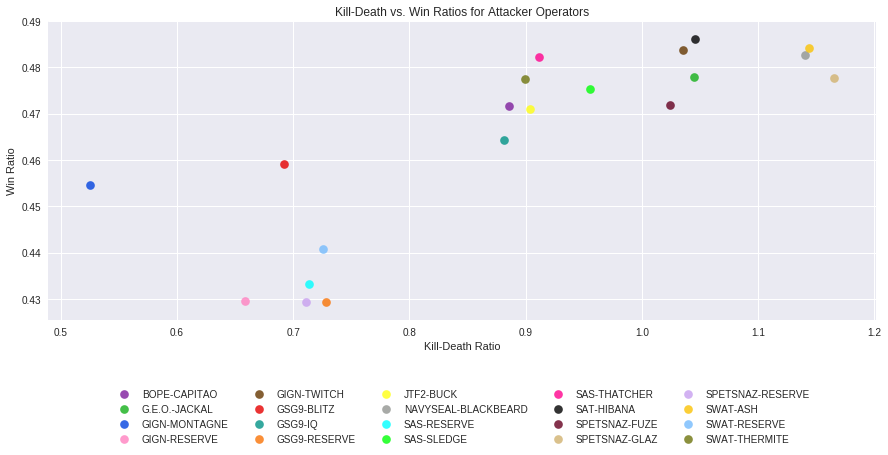

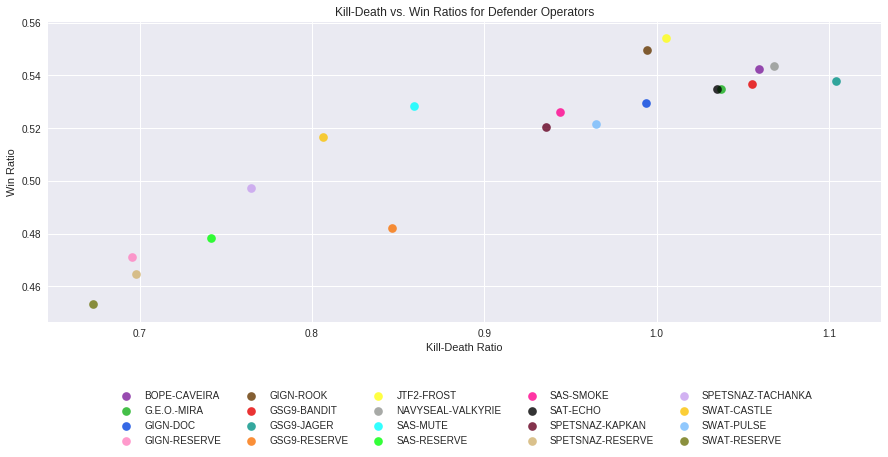

In [9]:
# Grouping by role and operator, disregarding skillrank
operator_groups = operators.groupby(['role', 'operator'], as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding k/d and win ratio columns
operator_groups['k/d_ratio'] = pd.to_numeric(operator_groups['nbkills']) / pd.to_numeric(operator_groups['nbdeaths'])
operator_groups['win_ratio'] = pd.to_numeric(operator_groups['nbwins']) / pd.to_numeric(operator_groups['nbpicks'])

# Splitting data by role
ops_roles = operator_groups.groupby('role')

# Graphing Attackers and Defenders on separate graphs
for role, tbl in ops_roles:
    sns.lmplot(x="k/d_ratio", y="win_ratio", data=tbl, fit_reg=False, hue='operator', \
               legend=False, palette=new_palette, size=5, aspect=2.5, scatter_kws={"s": 75})
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title('Kill-Death vs. Win Ratios for ' + role + ' Operators')
    plt.xlabel('Kill-Death Ratio')
    plt.ylabel('Win Ratio')
sns.plt.show()

<p>
For Attacker Operators, it appears there is a positive relationship between getting more kills than deaths and winning comparitively more often. The plot above illustrates how certain operators in the Attacker role have a better shot at winning rounds because they are able to get more kills during these rounds. 

<p>
The operator GIGN-MONTAGNE is shown to have the lowest kill-death ratio and would fall in the lower tier for win rate. The plot also shows how the five RESERVE operators all struggle to win and have lower kill-death ratios in comparison to most operators. For experienced players, this makes sense since these 'default' operators do not have the special gadgets, sights, or tools that are made available to the other operators - there's a clear disadvantage in choosing to play as a RESERVE (this is actually supported with a plot further down this tutorial). 

<p> 
On the positive side, SAT-HIBANA has the highest win-rate out of these operators and is one of just four operators to have a kill-death ratio above 1.0 and a win-rate that high (above 0.48). SPETSNAZ-GLAZ has the highest kill-death ratio for Attackers.
<p>
For Defender Operators, the corresponding plot above also shows a positive relationship between kill-death ratio and win ratio. The scales for each axis are slightly different when compared to the Attacker operator plot with win ratio getting close to 0.56 and kill-death ratio staying above 0.65. 12 out of the 20 Defender operators also have kill-death ratios above 0.9 with 0.52 as the lower bound for win ratios for those operators. In contrast, 10 out of the 20 Attacker operators are above a 0.9 kill-death ratio, but all 10 fall below 0.49 for win ratio (0.47 being the lower bound for this group). 

<p> 
For the same reasons mentioned earlier, the RESERVEs clearly struggle as Defenders as well. JTF2-FROST has the highest overall win-rate across Defender operators and GSG9-JAGER has the highest kill-death ratio. 
<h2> Graphing Picks and Win Ratios by Rank </h2>
* Only Operators data is used

We've already shown how operators in general perform differently based on kill-death and win ratio. Now let's investigate how the picks differ across the ranks. We will start with the original simplified dataframe again. Grouping by skillrank, role, and operator, we can sum up the number of wins, kills, deaths, and picks for each group.  

In [10]:
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each rank, role, and operator
ops_by_rank = operators.groupby(['skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981
3,Bronze,Attacker,GIGN-RESERVE,377,432,701,946
4,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941


A common question when performing data analysis is whether or not standardization is necessary. Let's take a look at the distribution of data within the operators dataset. The total number of picks based on rank should suffice as a valid metric to check how the data is distributed for Attackers and Defenders. Essentially, total number of picks is equal to the number of players in each rank. Only one player can pick one character per round.

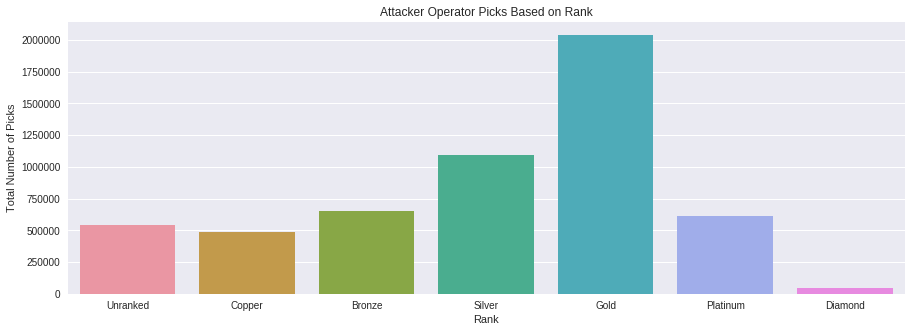

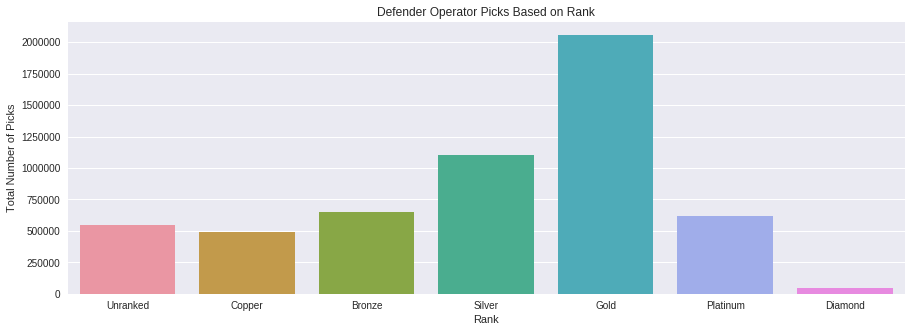

In [11]:
# Group: rank and role
# Summing the number of wins, kills, deaths, and picks for each group
total_ops_by_rank = operators.groupby(['skillrank', 'role'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Splitting data by role
total_ops_role = total_ops_by_rank.groupby('role')

# Order is used to determine categorical variables for the x-axis
order = ['Unranked','Copper','Bronze','Silver','Gold','Platinum','Diamond']

# Graphing Attackers and Defenders on separate graphs
for role, tbl in total_ops_role:
    plt.figure(figsize=(15,5))
    sns.barplot(x="skillrank", y="nbpicks", data=tbl, order=order)
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(role +' Operator Picks Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Total Number of Picks')
sns.plt.show()

First just wanted to note that the graphs for each role look the same, and that's because they are. They should be the same because for every picked Attacker operator, there will always be a picked Defender operator. Sometimes uneven teams may occur, but in ranked this rarely happens.
<p>
From both graphs, we see that standardization is quite necessary in the data. There are a lot more picks for each operator across both roles in Silver and Gold, while Diamond has the fewest amount of picks. As players ourselves, we know that this happens because most players are in Silver and Gold, while only a small group of elite players are in Diamond. To standardize we will use the preprocessing library from scikit learn. 

In [12]:
frames =  []
sd_ops_by_rank = ops_by_rank.groupby(['skillrank','role'], as_index=False)

for group, tbl in sd_ops_by_rank:
        tbl['scaled_nbpicks'] = preprocessing.scale(tbl['nbpicks'])
        frames.append(tbl)
sd_ops_by_rank = pd.concat(frames)
sd_ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks,scaled_nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383,-0.712957
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492,0.543624
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981,-0.228922
3,Bronze,Attacker,GIGN-RESERVE,377,432,701,946,-1.315477
4,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941,0.896238


Now that the number of picks for each operator are standardized (within their respective ranks), we can graph the results.

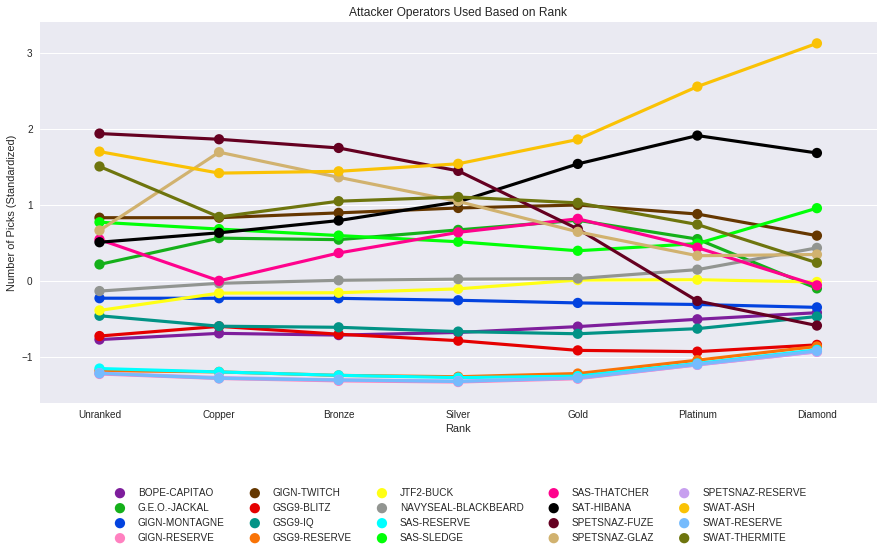

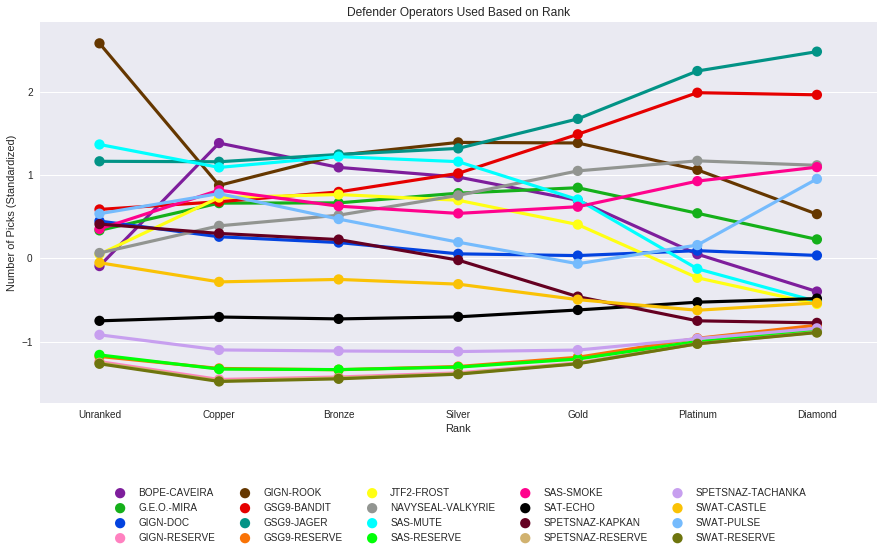

In [13]:
# Order is used to determine categorical variables for the x-axis
order = ['Unranked','Copper','Bronze','Silver','Gold','Platinum','Diamond']

# Splitting data by role
ops_by_rank_role = sd_ops_by_rank.groupby('role')

# Graphing Attackers and Defenders on separate graphs
for role, tbl in ops_by_rank_role:
    plt.figure(figsize=(15,7))
    sns.pointplot(x="skillrank", y="scaled_nbpicks", hue="operator", data=tbl, \
                  legend=False, palette=new_palette, size=5, aspect=2.5, order=order);
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(role +' Operators Used Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Number of Picks (Standardized)')
sns.plt.show()

<p>
With these standardized results, we can show which operators are more commonly or less commonly chosen at each rank. At first glance of the Attacker plot above, we can see two operators go in completely opposite directions as we progress in rank. SPETSNAZ-FUZE is at its peak in terms of number of picks in the Unranked stages but as the players get more skilled and compete in higher ranks, this operator seems to be a much less popular choice. SWAT-ASH, on the other hand, is the most popular choice in Silver through Diamond, where it is most evident by far. SPETSNAZ-GLAZ is the second most popular pick in Copper, but he begins to dip a bit in the higher ranks. Several of the other operators do not fluctuate too much as seen in the plot. 
<p> 
One thing worth noting is how uncommon it is for players to play as the default RESERVE operators. They are consistently at the bottom for each rank and their standardized pick values are under -1. 
<p>
We can analyze similar trends for the Defender operators. GIGN-ROOK is interestingly a very common pick in Unranked rounds - he is still a relatively common pick at higher ranks, but his standardized value in Unranked is the highest in the plot. GIGN-DOC is the most popular choice in Copper, but by Diamond, he is with the bottom of the pack. Both GSG9-BANDIT and GSG9-JAGER are picked more often as we progress in rank with a noticeable gap between these two operators and the rest in Diamond. 

<p>
Again, we see all the RESERVE operators not chosen very often at all. 
<hr>
Now that we've shown that there are significant differences in what operators are picked among ranks, we also will want to map out how each operator actually does with regards to win-ratio in each rank. We'll need to calculate the win ratio for each operator, within each rank, just like we did with kill-death ratio. And again, the data will be split into Attackers and Defenders.

In [14]:
# Empty list of frames, so all the dataframes can be concatenated in the end
frames =  []

# Grouping by skillrank and role
wr_ops_by_rank = ops_by_rank.groupby(['skillrank','role'], as_index=False)

# Calculating win ratio for each grouping
for group, tbl in wr_ops_by_rank:
        tbl['win_ratio'] = pd.to_numeric(tbl['nbwins']) / pd.to_numeric(tbl['nbpicks'])
        frames.append(tbl)
wr_ops_by_rank = pd.concat(frames)
wr_ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks,win_ratio
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383,0.463564
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492,0.469489
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981,0.451243
3,Bronze,Attacker,GIGN-RESERVE,377,432,701,946,0.398520
4,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941,0.477058


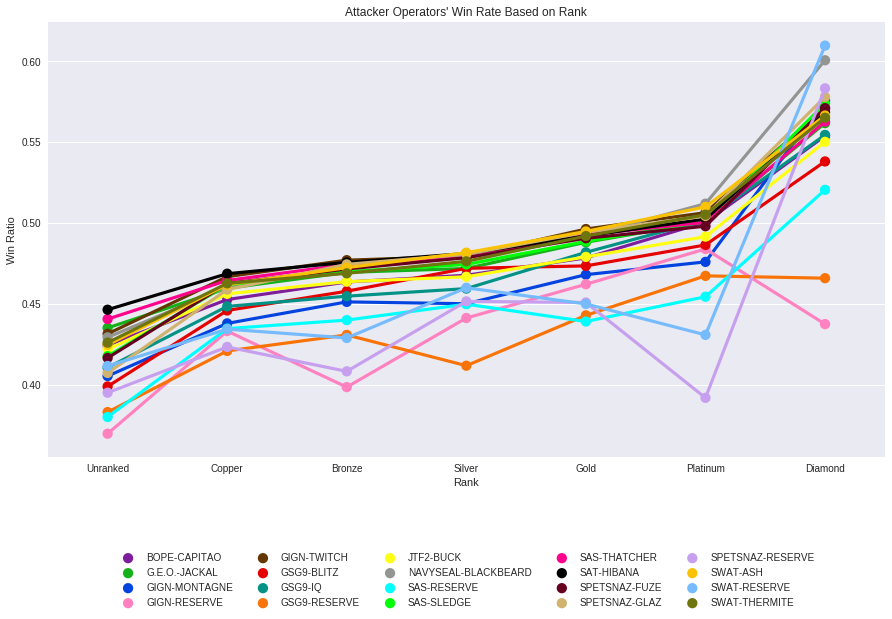

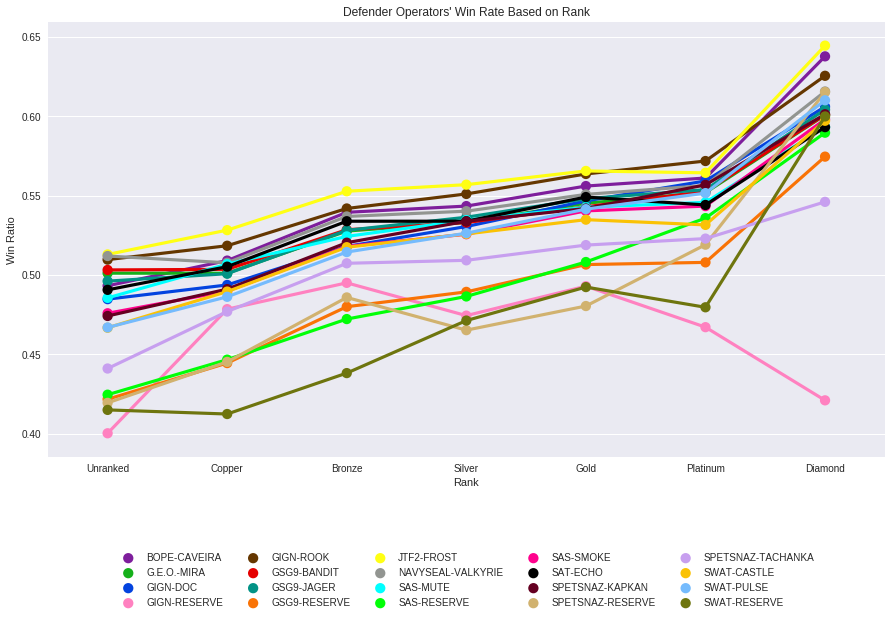

In [15]:
# Splitting data by role
wr_ops_by_rank_role = wr_ops_by_rank.groupby('role')

# Graphing Attackers and Defenders on separate graphs
for role, tbl in wr_ops_by_rank_role:
    plt.figure(figsize=(15,8))
    sns.pointplot(x="skillrank", y="win_ratio", hue="operator", data=tbl, \
                  legend=False, palette=new_palette, size=5, aspect=2.5, order=order);
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(role + ' Operators\' Win Rate Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Win Ratio')
sns.plt.show()

<p>
On average, the Attacker operators with the highest win rates at each rank include SAT-HIBANA, SAS-THATCHER, NAVYSEAL-BLACKBEARD, and few others as well based on how several lines look like they're written over each other. GSG9-BLITZ, GIGN-MONTAGNE, and GSG9-IQ seem to fall below the rest of the operators at each rank. For the RESERVE operators, there seems to be a lot of fluctuation due to how uncommon they are picked. This is especially evident in Diamond where two have very high win rates, but that could be attributed to how few players are in Diamond and the overall sample size involving these RESERVEs.
<p>
On the other hand, the Defender operators with the highest win rates include JTF2-FROST, GIGN-ROOK, and BOPE-CAVEIRA. One operator who sticks out as a pretty poor choice if you are focused on winning at each rank is SPETSNAZ-TACHANKA. Disregarding the RESERVEs who fluctuate a ton for the same reasons mentioned for the Attackers, the main operators seem to create a noticeable gap between themselves and SPETSNAZ-TACHANKA. 
<h2> Graphing Win Ratios Based on Map and Operator </h2>
* Only Objectives data is used

<p> 
With all these plots focusing on win rate and number of picks across the board for each operator, we also wanted to explore how well operators perform in regard to win rate based on the map. This is where the Objectives data comes into play to hopefully show which operators are best or worst to use depending on the randomly chosen map for the match. 

In [16]:
# Group: mapname, role, operator
# Summing number of wins, kills, deaths, and picks for each group
objectives_map = objectives.groupby(['mapname', 'role', 'operator'], as_index=False)\
                    ['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding win ratio columns to Objectives data
objectives_map['kd_ratio'] = pd.to_numeric(objectives_map['nbkills']) / pd.to_numeric(objectives_map['nbdeaths'])
objectives_map['win_ratio'] = pd.to_numeric(objectives_map['nbwins']) / pd.to_numeric(objectives_map['nbpicks'])
objectives_map.head()

,mapname,role,operator,nbwins,nbkills,nbdeaths,nbpicks,kd_ratio,win_ratio
0,BANK,Attacker,BOPE-CAPITAO,1902,2778,3201,4321,0.867854,0.440176
1,BANK,Attacker,G.E.O.-JACKAL,7432,12435,11690,16333,1.063730,0.455030
2,BANK,Attacker,GIGN-MONTAGNE,2957,2619,5043,6941,0.519334,0.426019
3,BANK,Attacker,GIGN-RESERVE,62,54,127,163,0.425197,0.380368
4,BANK,Attacker,GIGN-TWITCH,6884,10439,10672,15419,0.978167,0.446462


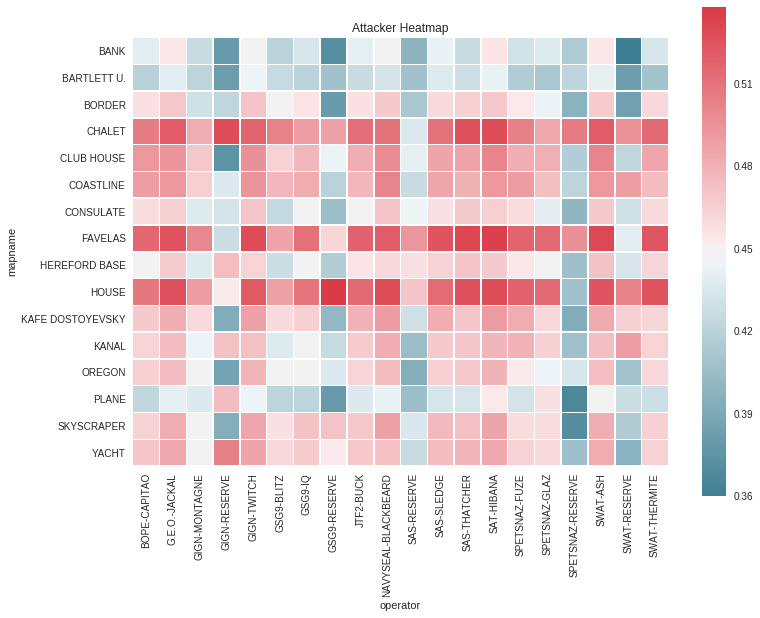

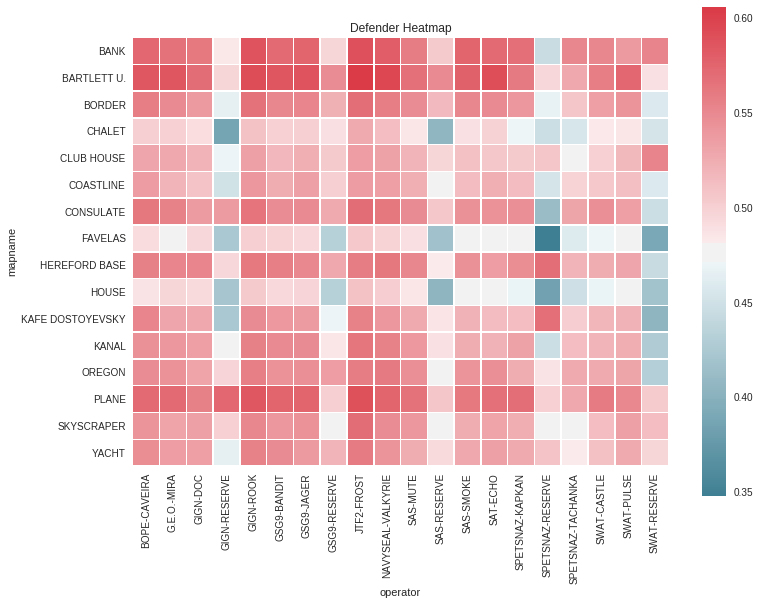

In [17]:
# Create the color scale
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Splitting data by role
objectives_map_role = objectives_map.groupby('role')

# Graph the heat map, warmer color is higher win rate, and vice versa for each role
for role, tbl in objectives_map_role:
    pivot = tbl.pivot(index='mapname', columns='operator', values='win_ratio')
    f, ax = plt.subplots(figsize=(12,9))
    plt.title(role + ' Heatmap')
    sns.heatmap(pivot, cmap=cmap, square=True, linewidths=.5, ax=ax)
plt.show()

After producing the two heatmaps above for Attackers and Defenders respectively, we realized it would be more effective to produce them while disregarding the RESERVE operators. The RESERVE operators were shown to be clearly a tier below all the other operators based on all of the previous plots - the context being that RESERVE operators do not have access to gun sights or any special gadgets or abilities. This ulimately leads to players struggling to get a higher kill-death ratio and a higher win rate. Additionally, this leads to players being aware of this struggle and rarely picking these RESERVE operators in ranked matches. For these heatmaps, the RESERVE operators have such low win rates that it makes it more difficult to differentiate between the other operators for each map. The resulting heatmaps without the RESERVE operators are plotted below. 

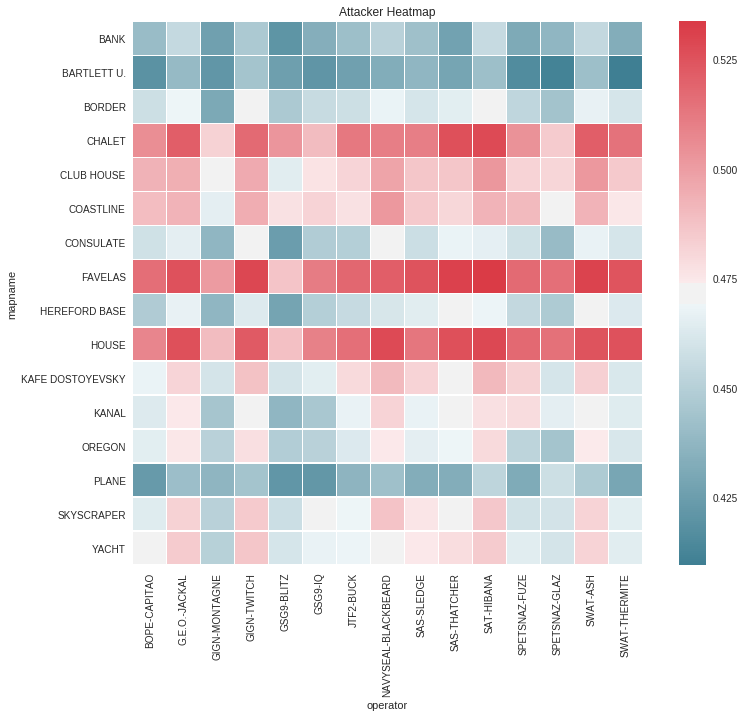

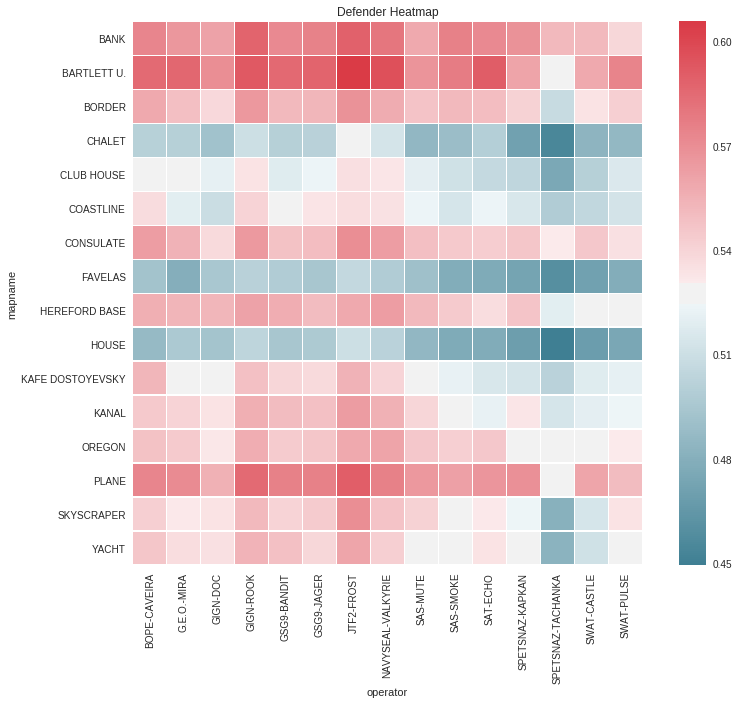

In [18]:
# Disregarding rows with "RESERVE" in the name
objectives_map_rm = objectives_map[objectives_map.operator.str[-7:] != "RESERVE"]

# Splitting data by role
objectives_map_rm_role = objectives_map_rm.groupby('role')

# Graph the heat map, warmer color is higher win rate, and vice versa for each role
for role, tbl in objectives_map_rm_role:
    pivot = tbl.pivot(index='mapname', columns='operator', values='win_ratio')
    f, ax = plt.subplots(figsize=(13,10))
    plt.title(role + ' Heatmap')
    sns.heatmap(pivot, cmap=cmap, square=True, linewidths=.5, ax=ax)
plt.show()

Across the board, Attacker operators seem to have a much easier time winning when the map is FAVELAS, HOUSE, or CHALET. CLUB HOUSE and COASTLINE are up there as well. Additionally, PLANE, BANK, and BARTLETT U. are darker blue across all these operators indicating the win rates are notably lower in comparison to all other combinations of operator and mapname. While some maps overall might give Attacker operators a comparatively higher or lower shot at winning, this heatmap also helps show which operators might be better to play as on maps that could be considered more even from their perspective. For example, G.E.O.-JACKAL, GIGN-TWITCH, NAVYSEAL-BLACKBEARD, SAT-HIBANA, and SWAT-ASH would be solid operator picks for the map OREGON. At the same time, SPETSNAZ-GLAZ SPETSNAZ-FUZE, and GIGN-MONTAGNE do not seem to win as often as those operators do on this map. 
<p>
What immediately stands out in the Defender heatmap is how these operators seem to have significantly lower win rates on FAVELAS, HOUSE, and CHALET based on the distribution of colors shown on the heatmap. This works well with the analysis on the Attacker heatmap showing higher win rates across the board for those operators in these same maps. We could go the opposite way and even say that Defender operators tend to have higher win rates in general versus Attacker operators. This is supported by all the red shown as well as the scale used in this heatmap and in the previous kill-death ratio vs. win ratio plots. Another observation worth noting is how poorly SPETSNAZ-TACHANKA performs in almost every map. 

Overall, teammates and operator combinations definitely factor into arriving at the win rates we calculated and used for these heatmaps, but all this definitely provides some early insight into how well operators perform in each map. 
<center>
<h3>In-Game Map: Consulate</h3>
<img src="https://ubistatic19-a.akamaihd.net/resource/en-us/game/rainbow6/siege/r6-game-info-map-consulate-01_211993.jpg" alt="Drawing" style="width: 700px;"/>
<hr>
<h1> Predicting Win Ratio </h1>
</center>
<p>
In this last section, the focus will be on developing a model that can accurately predict the win percentage of a round. There's a variety of prediction models we could use, but given the amount of different categories we have for each operator, rank, and map, we will solely focus on linear regression. 
<p>
When fitting a model, it's required to at least split the data into a training and test set. So, each time a new model is being made, the data in use will be split as such. Additionally, we will use a technique called <a href="https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f">one-hot encoding</a> to transform categorical variables in the dataset so the Linear Regression library in scikit can fit those variables correctly. Below, a function is defined to perform <a href="https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f">one-hot encoding</a> on appropriate variables in the dataframe passed as an argument. The function recognizes which variables to encode so column filtering of the dataframe is not necessary before passing it in as an argument. 

In [19]:
# Source referenced: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

def dummyEncode(df):
    # Filters through dataframe and recognizes categorical variables
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

Now we can move on to fitting Linear Regression on the Operators/Objectives data. We will split data into train/test, create a model, predict win ratio using the test split, and then evaluate the model.

<p>
<h2>Linear Regression for Operators</h2>
<p>
First is the Operators data, in which we will use the ops_by_rank dataframe created back in Exploratory Data Analysis. We'll need to add k/d ratio as a predictor, and then remove nbwins, nbkills, nbdeaths, and nbpicks. We'll then pass in the dataframe to the dummyEncode function written above. Win ratio will be added for the next part, where it will become the dependent variable. Of course, we won't use win ratio as a predictor.

In [20]:
# Operator Predictors: rank, operator, role, kd
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each rank, role, and operator
ops_by_rank = operators.groupby(['skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding kill-death and win ratios
ops_by_rank['kd_ratio'] = pd.to_numeric(ops_by_rank['nbkills']) / pd.to_numeric(ops_by_rank['nbdeaths'])
ops_by_rank['win_ratio'] = pd.to_numeric(ops_by_rank['nbwins']) / pd.to_numeric(ops_by_rank['nbpicks'])

# Dropping nbwins, nbkills, nbdeaths, nbpicks
ops_df = ops_by_rank.drop(["nbwins", "nbkills", "nbdeaths", "nbpicks"], axis=1)
ops_df = dummyEncode(ops_df)
ops_df.head()

,skillrank,role,operator,kd_ratio,win_ratio
0,0,0,0,0.842073,0.463564
1,0,0,2,0.990049,0.469489
2,0,0,5,0.504049,0.451243
3,0,0,6,0.616262,0.398520
4,0,0,8,0.966876,0.477058


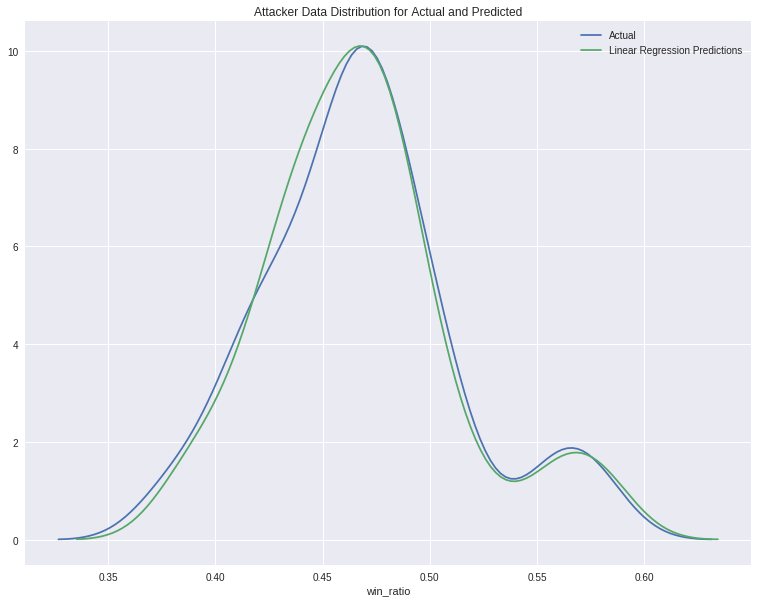

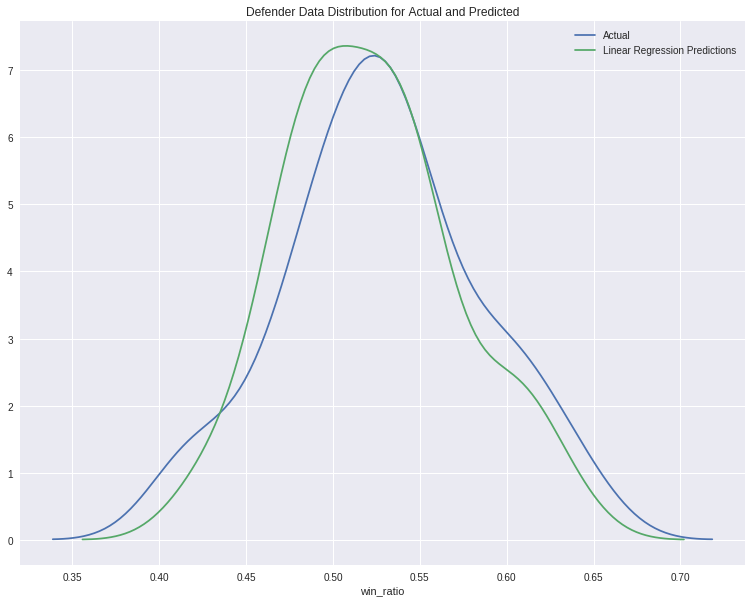

In [21]:
# Split data by Attacker/Defender
ops_df_role = ops_df.groupby('role')
models = []

for role, tbl in ops_df_role:
    X = tbl.drop('win_ratio', axis=1)
    y = tbl['win_ratio']
    
    # Split data into Train and Test
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
    X_train['win_ratio'] = y_train
    
    # Fit the Linear Regression on Train split
    lr = smf.ols(formula='win_ratio ~ C(skillrank) + C(operator) + kd_ratio', data=X_train).fit()
    models.append(lr)
    
    # Predict using Test split
    preds_lr = lr.predict(X_test)

    # Plot how the predicted win_ratio compares to actual win ratio
    f, ax = plt.subplots(figsize=(13,10))
    role_name = 'Attacker' if role == 0 else 'Defender'
    plt.title(role_name + ' Data Distribution for Actual and Predicted')
    sns.distplot(y_test, hist=False, label="Actual", ax=ax)
    sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

sns.plt.show()

As you can see, both models performed fairly well; the predicted distribution essentially matches the actual distribution fairly well. However, there needs to be a real metric that can be tested to show how well each model fits. The F-Test for Goodness of fit will be performed for each model. If the F-Value is greater than the calculated F-Statistic (obtained from a table of values), and the P-Value is less than alpha (which is 0.05 in our case), a significant model has been produced.

In [22]:
# Import F-Table to look up F-Statistic
from scipy.stats import f

# F-Test to evaluate goodness of fit
for index, model in enumerate(models):
    test = model.f_test(np.identity(len(model.params)))
    role = 'Attacker' if index == 0 else 'Defender'
    print(role + ' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
          ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

Attacker Model - Calculated F-Statistic: 1.64325726998 F-Value: 2919.13866605 P-Value: 8.729267450134222e-98
Defender Model - Calculated F-Statistic: 1.64325726998 F-Value: 13784.0049579 P-Value: 1.0577455839156775e-121


Success! We have produced a significant model for both Attackers and Defenders because both F-Values are greater than their respective calculated F-Statistics and both P-Values are less than 0.05. These models can significantly predict the win-ratio for the Operators dataset.

<h2>Linear Regression for Objectives</h2>

In [23]:
# Objective Predictors: mode, map, rank, operator, role, kd
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks 
# for each mode, map, rank, operator, role, kd
obj_by_rank = objectives.groupby(['mapname','gamemode','skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Can't divide by 0 in kd if number of deaths is 0. Common procedure to change all of these to a 1
# This is only a problem in the Objectives dataset
mask = obj_by_rank.nbdeaths == 0
obj_by_rank.loc[mask, 'nbdeaths'] = 1

# Adding kill-death and win ratios
obj_by_rank['kd_ratio'] = pd.to_numeric(obj_by_rank['nbkills']) / pd.to_numeric(obj_by_rank['nbdeaths'])
obj_by_rank['win_ratio'] = pd.to_numeric(obj_by_rank['nbwins']) / pd.to_numeric(obj_by_rank['nbpicks'])

obj_df = obj_by_rank.drop(["nbwins", "nbkills", "nbdeaths", "nbpicks"], axis=1)
obj_df = dummyEncode(obj_df)
obj_df.head()

,mapname,gamemode,skillrank,role,operator,kd_ratio,win_ratio
0,0,0,0,0,0,0.812500,0.460317
1,0,0,0,0,2,1.148594,0.429379
2,0,0,0,0,5,0.413534,0.396552
3,0,0,0,0,6,0.375000,0.200000
4,0,0,0,0,8,0.835938,0.424403


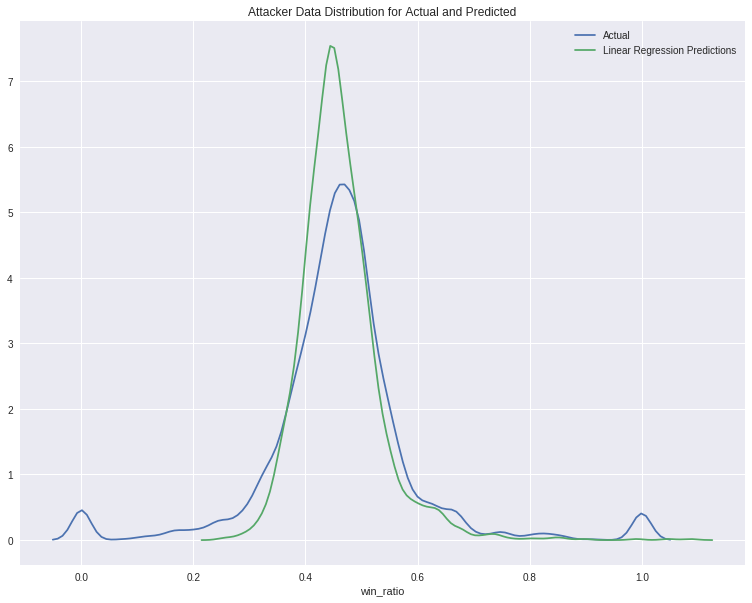

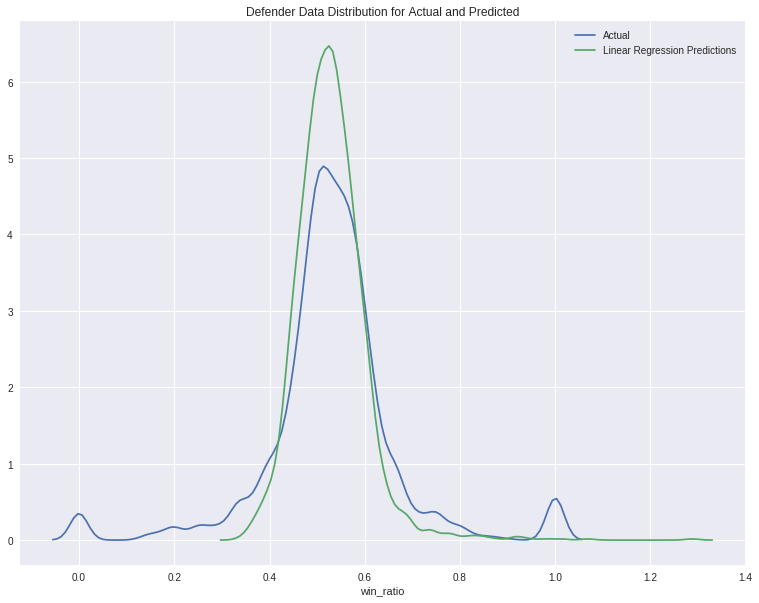

In [24]:
# Split data by Attacker/Defender
obj_df_role = obj_df.groupby('role')
models_obj = []

for role, tbl in obj_df_role:
    X = tbl.drop('win_ratio', axis=1)
    y = tbl['win_ratio']
    
    # Split data into Train and Test
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
    X_train['win_ratio'] = y_train
    
    # Fit the Linear Regression on Train split
    lr = smf.ols(formula='win_ratio ~ C(mapname) + C(gamemode) + C(skillrank) + C(operator) + kd_ratio', data=X_train).fit()
    models_obj.append(lr)
    
    # Predict using Test split
    preds_lr = lr.predict(X_test)

    # Plot how the predicted win_ratio compares to actual win ratio
    f, ax = plt.subplots(figsize=(13,10))
    role_name = 'Attacker' if role == 0 else 'Defender'
    plt.title(role_name + ' Data Distribution for Actual and Predicted')
    sns.distplot(y_test, hist=False, label="Actual", ax=ax)
    sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

sns.plt.show()

In [25]:
# Import F-Table to look up F-Statistic
from scipy.stats import f

# F-Test to evaluate goodness of fit
for index, model in enumerate(models_obj):
    test = model.f_test(np.identity(len(model.params)))
    role = 'Attacker' if index == 0 else 'Defender'
    print(role + ' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
          ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

Attacker Model - Calculated F-Statistic: 1.37744476704 F-Value: 1644.70571562 P-Value: 0.0
Defender Model - Calculated F-Statistic: 1.37744541983 F-Value: 2099.29378257 P-Value: 0.0


Again, we seem to have found significant models for predicting the win ratio in the Objectives dataset with a model that has mapname, gamemode, skillrank, operator, and kd_ratio as predictors. The F-Values are greater than the F-Statistics, and both P-Values are less than 0.05.

<center>
<h3>In-Game Map: House</h3>
<img src="https://ubistatic19-a.akamaihd.net/resource/en-us/game/rainbow6/siege/r6-game-info-map-house-01_211956.jpg" alt="Drawing" style="width: 700px;"/>
<hr>
<h1> Conclusion and Further Exploration </h1>
</center>

Even though Rainbow Six Siege is an incredibly popular game, you rarely see game developers and analysts release all this in-game data out to the public. We actually learned a lot about the game thanks to this data dump and covered quite a bit of the data science pipeline presented to us throughout our data science course, CMSC320. As you might be able to tell, this game can be very complex, but hopefully this tutorial provided some valuable insight for both inexperienced and experienced players. Even if you're not interested in this game, a lot of what we cover could certainly apply to other datasets since data science is all about tidying datasets, preparing them for further analysis, and finally plotting and explaining any relevant visualizations or models. 

If you are interested in Rainbow Six Siege, there is much data left to explore. We only focused on PC players and the first million or so lines from the Operators dataset, so similar analyses could be performed on PS4 and Xbox One players. In addition, the Objectives dataset featured a column entitled 'objectivelocation'. If you play this game, you know that the location of the hostage or bombs or designated areas are randomly placed between a set of locations for a map. This might play a factor in kill-death and win ratios, but we chose to focus on maps as a whole. Finally, the initial data dump featured a 19.3GB file filled with even more in-game data like team composition, time played, gun attachments, and more. This tutorial was just a taste of the incredible amounts of data game developers and analysts have to take into account, and we hope it was worth the read! 


<center>
<img src="http://www.gamerassaultweekly.com/wp-content/uploads/2015/12/FlawlessVictory-1200x520.png" alt="Drawing" style="width: 900px;"/>
</center>